***Data Pre-Processor***


In [1]:
%run deepfake_dataloader.py
%run utils.py

In [2]:
import h5py
import torch
import numpy as np

# Pretty Print
import pprint
pp = pprint.PrettyPrinter(width=20)

In [3]:
# image_folder_path='/home/jupyter/image_folder_faceshq/Frequency/Faces-HQ'
image_folder_path='/home/jupyter/image_folder_BCCC_256/'
batch_sz = 32 # 

dataloader = get_preprocessors(
    image_root=image_folder_path, 
    output_size=182,
    batch_size=32,
    num_workers=16,
    destf_hdf5='/home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5',
    transforms=convert_to_256
)

total_imgs  = len(dataloader.dataset.samples)
data_origin = dataloader.dataset.class_to_idx
data_origin.update({y:x for x,y in data_origin.items()})
print(dataloader.dataset)
print('Classes:')
pp.pprint(dataloader.dataset.classes)
print(data_origin)

/home/jupyter/image_folder_BCCC_256/
Dataset DeepFakePreProcessor
    Number of datapoints: 80003
    Root location: /home/jupyter/image_folder_BCCC_256/
Classes:
['lsun_bedrooms',
 'lsun_cars',
 'lsun_cats',
 'lsun_churches',
 'stylegan1_bedrooms',
 'stylegan2_cars',
 'stylegan2_cats',
 'stylegan2_churches']
{'lsun_bedrooms': 0, 'lsun_cars': 1, 'lsun_cats': 2, 'lsun_churches': 3, 'stylegan1_bedrooms': 4, 'stylegan2_cars': 5, 'stylegan2_cats': 6, 'stylegan2_churches': 7, 0: 'lsun_bedrooms', 1: 'lsun_cars', 2: 'lsun_cats', 3: 'lsun_churches', 4: 'stylegan1_bedrooms', 5: 'stylegan2_cars', 6: 'stylegan2_cats', 7: 'stylegan2_churches'}


In [4]:
progress = ProgressMonitor(length=total_imgs)
rad_len  = 182
hdf5_fn  = 'LSUN_BCCC_256.hdf5'
with h5py.File(hdf5_fn, 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, rad_len), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    img_size  = f.create_dataset('img_size',  (total_imgs,),     dtype='i')
    data_size = f.create_dataset('data_size', (total_imgs,),     dtype='i')
    filename  = f.create_dataset('file_name', (total_imgs,),     dtype='S100')
    
    for i, (img_data, target, origin_dataset, _, _, path) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(img_data.shape[0]):
            idx = start_idx + j
            progress.update(1, 0)
            if (target[j] > 1):
                print(target[j])
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]
            img_size[idx]  = data_img_size[origin_dataset[j]]
            data_size[idx] = rad_size[origin_dataset[j]]
            filename[idx]  = np.string_(path[j])
        

In [ ]:
import matplotlib.pyplot as plt

with h5py.File(hdf5_fn, 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[200])
    for i in range(10):
        plt.plot(dset[np.random.randint(20000)])
#         plt.show()
    plt.show()

In [21]:
count = 0
with h5py.File(hdf5_fn, 'r') as f:
    dset = f['file_name']
    for i in range(len(dset)):
        print()
        count += 1
        arr = np.frombuffer(dset[i], dtype=np.uint8)
        print(arr.shape)
        arr = np.pad(arr, (0,100-arr.shape[0]), 'constant', constant_values=(0))
        print(arr)
        print(arr.shape)
        out_str = np.char.decode(np.ndarray.tostring(arr))
        print(out_str)
        if count > 10:
            break


(78,)
[ 47 104 111 109 101  47 106 117 112 121 116 101 114  47 105 109  97 103
 101  95 102 111 108 100 101 114  95  66  67  67  67  95  50  53  54  47
 115 116 121 108 101 103  97 110  49  95  98 101 100 114 111 111 109 115
  47 115 116 103  49  45  98 101 100 114 111 111 109  45  48  48  56  55
  48  53  46 112 110 103   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
(100,)
/home/jupyter/image_folder_BCCC_256/stylegan1_bedrooms/stg1-bedroom-008705.png

(63,)
[ 47 104 111 109 101  47 106 117 112 121 116 101 114  47 105 109  97 103
 101  95 102 111 108 100 101 114  95  66  67  67  67  95  50  53  54  47
 115 116 121 108 101 103  97 110  50  95  99  97 116 115  47 115 101 101
 100  56  52  57  51  46 112 110 103   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
(100,)
/home/jupyter/image_folder_BCCC_256/stylegan2_cats/seed8493.png

(61,)
[ 47 104

In [ ]:
!gcloud auth activate-service-account --key-file ./playground-270702-4d2df0765336.json

In [ ]:
# auth.authenticate_user()

project_id = 'playground-270702'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'img-hosting-bucket'
!gsutil -m cp -r /home/jupyter/CSE253_FinalProject/LSUN_BCCC_256.hdf5 gs://{bucket_name}/

In [ ]:
!wget https://storage.googleapis.com/img-hosting-bucket/LSUN_BCCC_256.hdf5

lsun_cars


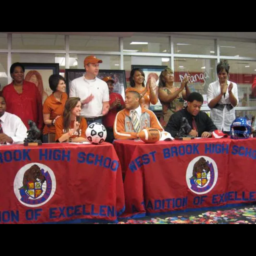

tensor(307.7090, dtype=torch.float64)
tensor(30.0924, dtype=torch.float64)


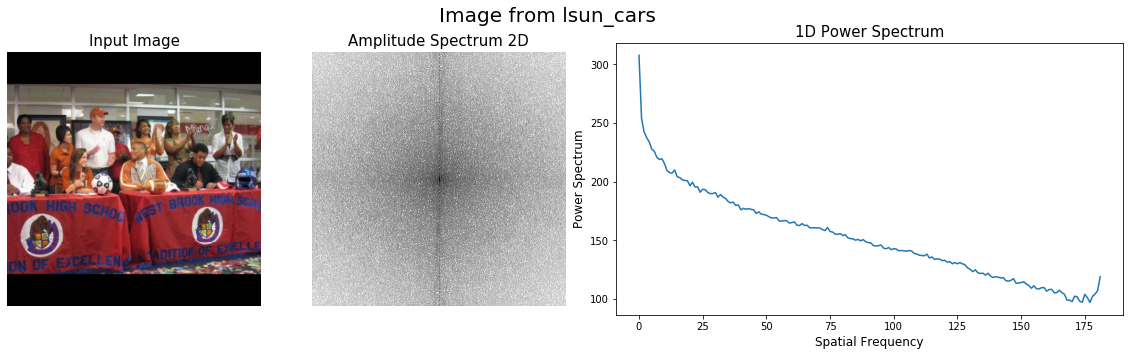

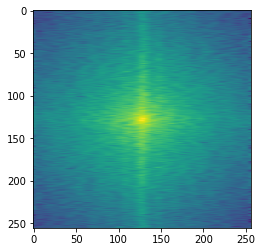

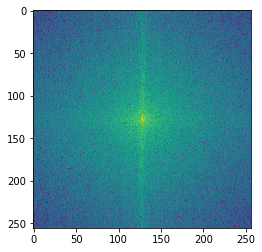

In [22]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import os
from PIL import Image
import random
from torchvision import transforms
import numpy as np
import scipy.signal as signal

b, a = signal.butter(8, 0.125)


file_name = './imgs/class_1'

(img_data, target, origin_dataset, img, ms_img, path) = next(iter(dataloader))
for i, dset in enumerate(origin_dataset):
    if dset == 'lsun_cars':
        print(dset)
        img_data = img_data[i]
        img      = img[i]
        origin_dataset = origin_dataset[i]
        target   = target[i]
        ms_img   = ms_img[i]
        break

sg2_img = transforms.ToPILImage()(img.permute(2, 0, 1))
display(sg2_img)
sg2_img.save('stylegan2_cars.png')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col',
                        gridspec_kw={'hspace': 1, 'wspace': 0.15, 'width_ratios': [1, 1, 2]},
                        figsize=(20, 5))
fig.suptitle('Image from ' + origin_dataset, fontsize=20)

ax1.axis('off')
ax2.axis('off')

ax1.set_title('Input Image',           size=15)
ax2.set_title('Amplitude Spectrum 2D', size=15)
ax3.set_title('1D Power Spectrum',     size=15)

ax1.imshow(img)
print(ms_img.max())
print(ms_img.min())
ax2.imshow(ms_img, cmap='Greys', norm=colors.Normalize(vmin=ms_img.min(), vmax=ms_img.max()))

plt.xlabel('Spatial Frequency', fontsize=12)
plt.ylabel('Power Spectrum',    fontsize=12)
ax3.plot(img_data)

plt.savefig(file_name + '.jpg', dpi=300)
plt.show()

y = signal.filtfilt(b, a, ms_img, padlen=150)

plt.imshow(y)
plt.figure()
plt.imshow(ms_img)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print(mcolors.BASE_COLORS)
print(mcolors.BASE_COLORS.keys())
print(list(mcolors.BASE_COLORS.keys())[0])
print(mcolors.TABLEAU_COLORS)
for k, v in mcolors.TABLEAU_COLORS.items():
    print(k, v)

In [ ]:
c = np.diag(np.arange(1, 10))
c[0] += 1
print(c)
print(np.mean(c, axis=0))
print(np.std(c, axis=0))